In [1]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

# Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 15)
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('ph_real_estate.csv')
df.head()

Description              Location  \
0  2-Bedroom Unit for Sale in Amisa Private Resid...     Mactan, Lapu-Lapu   
1  1-Bedroom Unit for Sale in Amisa Private Resid...     Mactan, Lapu-Lapu   
2  Offices at The Galleon - Prime Unit (11G) for ...    San Antonio, Pasig   
3  1-Bedroom Unit (821) for Sale in Maple at Verd...          Ugong, Pasig   
4  Alice 2 Storey Townhouse For Sale in Lancaster...  Tapia, General Trias   

  Price (PHP) Bedrooms Bath Floor_area (sqm) Land_area (sqm)    Latitude  \
0  15,916,180        2    2               74              na  10.3051555   
1   8,730,355        1    1               41              na  10.3051555   
2  27,448,000       na   na               82              na   14.588716   
3  16,011,000        1   na               58              na   14.588882   
4   1,935,600        3   na               40              40    14.35507   

    Longitude                                               Link  
0  124.011241  https://www.lamudi.com.ph/2-bedroom-unit-for-s...  
1  124.011241  https://www.lamudi.com.ph/1-bedroom-unit-for-s...  
2  121.060009  https://www.lamudi.com.ph/offices-at-the-galle...  
3  121.079016  https://www.lamudi.com.ph/1-bedroom-unit-821-f...  
4  120.876425  https://www.lamudi.com.ph/alice-2-storey-townh...

# Data Wrangling

In [3]:
# Lower the columns, whitespace and remove (PHP) and (SQM)
df.columns = df.columns.str.lower().str.replace(r'\(php\)|\(sqm\)', '', regex=True).str.strip()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  1500 non-null   object 
 1   location     1500 non-null   object 
 2   price        1500 non-null   object 
 3   bedrooms     1500 non-null   object 
 4   bath         1500 non-null   object 
 5   floor_area   1500 non-null   object 
 6   land_area    1500 non-null   object 
 7   latitude     1500 non-null   object 
 8   longitude    1500 non-null   float64
 9   link         1500 non-null   object 
dtypes: float64(1), object(9)
memory usage: 117.3+ KB


In [5]:
df.query('bedrooms == "na"').bedrooms.size

120

In [6]:
df.query('bath == "na"').bath.size

633

In [7]:
df.query('land_area == "na"').land_area.size

1171

In [8]:
df.query('floor_area == "na"').floor_area.size

58

In [9]:
df.query('price == "na"').price.size

40

In [10]:
non_numeric_lat = df.latitude.str.contains(r'[^0-9.]')

non_numeric_lat.value_counts()

False    1479
True       21
Name: latitude, dtype: int64

In [11]:
df.query('@non_numeric_lat').head()

description  \
302  Beach Lot for Sale in Seafront Residences, San...   
368  Pre-Selling 1-Bedroom Executive Unit (54.50 sq...   
421  4-Bedroom Beach House and Lot for Sale in Seaf...   
440  RFO 2-Bedroom Unit (63.60 sqm) in The Radiance...   
470  2-Storey 4BR House and Lot (Luciana Model) for...   

                   location       price bedrooms bath floor_area land_area  \
302   Calubcub II, San Juan   5,700,000       na   na         na       295   
368    Pasay Rotonda, Pasay  12,100,000        1   na         54        na   
421   Calubcub II, San Juan  14,100,000        4   na        150       200   
440    Pasay Rotonda, Pasay  12,000,000        2   na         63        na   
470  Antipolo del Sur, Lipa   8,381,730        4   na        174       176   

      latitude  longitude                                               link  
302  13.74067t    121.428  https://www.lamudi.com.ph/beach-lot-for-sale-i...  
368  14.55781t    120.989  https://www.lamudi.com.ph/pre-selling-1-bedroo...  
421  13.74067t    121.428  https://www.lamudi.com.ph/4-bedroom-beach-hous...  
440  14.55781t    120.989  https://www.lamudi.com.ph/rfo-2-bedroom-unit-6...  
470  13.91295t    121.185  https://www.lamudi.com.ph/2-storey-4br-house-a...

Okay, so the null values are replaced with a string "na", and as I see we have too many NA. I would just drop these columns and use lot area, bedrooms and price for analysis. We will also remove the commas in the price, and typos in the latitude.

## Cleaning the data

Dropping land_area, link and bath.

In [12]:
df = df.drop(columns=['land_area', 'bath', 'link'], axis=1)
df.columns

Index(['description', 'location', 'price', 'bedrooms', 'floor_area',
       'latitude', 'longitude'],
      dtype='object')

Now let's remove the rows with NA in bedrooms, price and floor_area.

In [13]:
df = df[(df.bedrooms != 'na') & (df.floor_area != 'na') & (df.price != 'na')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  1326 non-null   object 
 1   location     1326 non-null   object 
 2   price        1326 non-null   object 
 3   bedrooms     1326 non-null   object 
 4   floor_area   1326 non-null   object 
 5   latitude     1326 non-null   object 
 6   longitude    1326 non-null   float64
dtypes: float64(1), object(6)
memory usage: 82.9+ KB


In [14]:
df.query('floor_area == "na"').floor_area.size, df.query('bedrooms == "na"').bedrooms.size, df.query('price == "na"').price.size

(0, 0, 0)

Removing commas in the price

In [15]:
# Remove commas from the 'Price' column
df.price = df.price.str.replace(',', '')
df.sample()

description  \
751  Studio Condo Unit (10D) for Sale in One Sierra...   

                       location    price bedrooms floor_area   latitude  \
751  Highway Hills, Mandaluyong  7636063        1         31  14.578255   

      longitude  
751  121.052143

Removing "t" in latitude

In [16]:
df.latitude = df.latitude.str.replace('t', '')
t_present = 't' in df.latitude.values
t_present

False

Now this is done. Let's change the dtypes so we can do statistics.

## Changing the dtypes

Data type transformation is a crucial step in optimizing memory usage, simplifying calculations, and enhancing the performance of data manipulation operations. By downcasting specific integer and floating-point values, we can reduce memory overhead while maintaining accuracy. Additionally, converting certain object data to categorical data types can improve memory efficiency and expedite operations that involve categorical variables. This process ensures that our data is stored and processed in the most efficient way possible, benefiting both memory consumption and computational speed.

**Float:**
- float16: range of approximately -65500.0 to 65500.0
- float32: range of approximately -3.4 x 10^38 to 3.4 x 10^38
- float64: range of approximately -1.8 x 10^308 to 1.8 x 10^308

**Int:**
- int8: range of -128 to 127
- int32: range of approximately -2.1 billion to 2.1 billion
- int64: range of approximately -9.2 x 10^18 to 9.2 x 10^18

In [17]:
df.head()

description  \
0  2-Bedroom Unit for Sale in Amisa Private Resid...   
1  1-Bedroom Unit for Sale in Amisa Private Resid...   
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
4  Alice 2 Storey Townhouse For Sale in Lancaster...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   

                     location     price bedrooms floor_area    latitude  \
0           Mactan, Lapu-Lapu  15916180        2         74  10.3051555   
1           Mactan, Lapu-Lapu   8730355        1         41  10.3051555   
3                Ugong, Pasig  16011000        1         58   14.588882   
4        Tapia, General Trias   1935600        3         40    14.35507   
5  Highway Hills, Mandaluyong   7587013        1         32   14.578255   

    longitude  
0  124.011241  
1  124.011241  
3  121.079016  
4  120.876425  
5  121.052143

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  1326 non-null   object 
 1   location     1326 non-null   object 
 2   price        1326 non-null   object 
 3   bedrooms     1326 non-null   object 
 4   floor_area   1326 non-null   object 
 5   latitude     1326 non-null   object 
 6   longitude    1326 non-null   float64
dtypes: float64(1), object(6)
memory usage: 82.9+ KB


In [19]:
df.floor_area.max(), df.bedrooms.max(), df.price.max()

('98', '5', '9833600')

In [20]:
dtypes = {
    'location': 'category',
    'price': 'int32',
    'bedrooms': 'int8',
    'floor_area': 'int32',
    'latitude': 'float64',
    'longitude': 'float64'
}
df = df.astype(dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   description  1326 non-null   object  
 1   location     1326 non-null   category
 2   price        1326 non-null   int32   
 3   bedrooms     1326 non-null   int8    
 4   floor_area   1326 non-null   int32   
 5   latitude     1326 non-null   float64 
 6   longitude    1326 non-null   float64 
dtypes: category(1), float64(2), int32(2), int8(1), object(1)
memory usage: 59.2+ KB


# Analyze & Visualize

In [21]:
df_copy = df.copy()
df_copy.head()

description  \
0  2-Bedroom Unit for Sale in Amisa Private Resid...   
1  1-Bedroom Unit for Sale in Amisa Private Resid...   
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
4  Alice 2 Storey Townhouse For Sale in Lancaster...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   

                     location     price  bedrooms  floor_area   latitude  \
0           Mactan, Lapu-Lapu  15916180         2          74  10.305155   
1           Mactan, Lapu-Lapu   8730355         1          41  10.305155   
3                Ugong, Pasig  16011000         1          58  14.588882   
4        Tapia, General Trias   1935600         3          40  14.355070   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   

    longitude  
0  124.011241  
1  124.011241  
3  121.079016  
4  120.876425  
5  121.052143

In [22]:
df_copy.describe().round(1)

price  bedrooms  floor_area  latitude  longitude
count       1326.0    1326.0      1326.0    1326.0     1326.0
mean    13457222.1       1.8        68.1      14.1      121.3
std     11960514.9       1.0        43.8       1.6        1.0
min       850000.0       1.0        17.0       7.1      120.5
25%      5717500.0       1.0        42.0      14.4      121.0
50%     10738887.5       1.0        57.0      14.6      121.1
75%     16322000.0       2.0        77.0      14.6      121.1
max    175265000.0       5.0       409.0      16.4      125.6

There's no unusual values. Let's start transforming our data to a better one for analysis.

## Condominium Dataframe

In [23]:
df_condo = df_copy.query(
    'description.str.lower().str.contains("condo|studio|unit|pre-selling") & ~description.str.lower().str.contains("house|home")'
).copy()
df_condo.head()

description  \
0  2-Bedroom Unit for Sale in Amisa Private Resid...   
1  1-Bedroom Unit for Sale in Amisa Private Resid...   
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   
6  Studio Deluxe (43E) for Sale in Empress at Cap...   

                     location     price  bedrooms  floor_area   latitude  \
0           Mactan, Lapu-Lapu  15916180         2          74  10.305155   
1           Mactan, Lapu-Lapu   8730355         1          41  10.305155   
3                Ugong, Pasig  16011000         1          58  14.588882   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   
6               Oranbo, Pasig  13246000         1          46  14.575822   

    longitude  
0  124.011241  
1  124.011241  
3  121.079016  
5  121.052143  
6  121.064324

In [24]:
df_condo['city'] = df_condo['location'].apply(lambda x: x.split(', ')[-1].lower())
# df_condo['location_type'] = df_condo.apply(lambda row: get_location_type(row['latitude'], row['longitude']), axis=1)

In [25]:
df_condo.columns

Index(['description', 'location', 'price', 'bedrooms', 'floor_area',
       'latitude', 'longitude', 'city'],
      dtype='object')

### Distribution

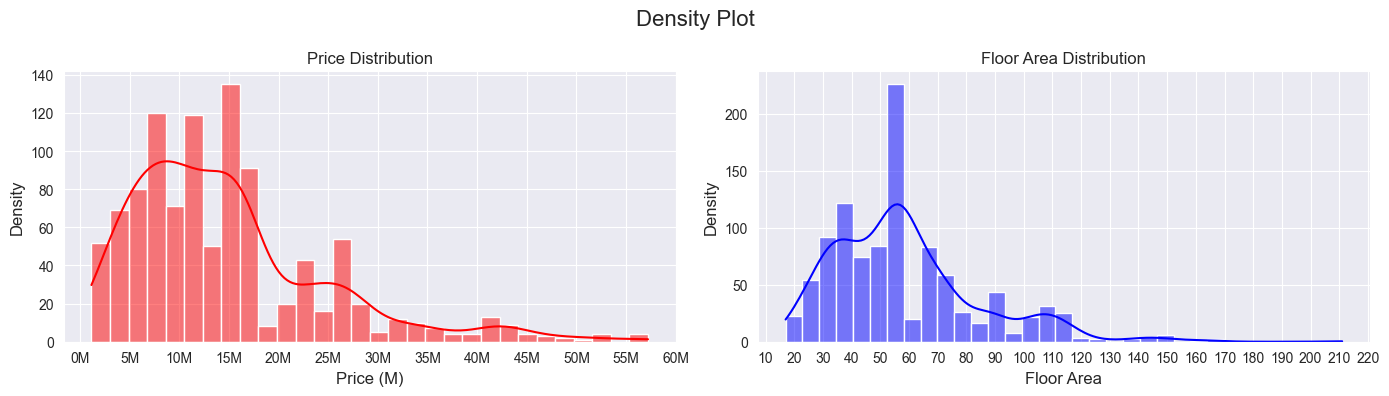

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Price
sns.histplot(data=df_condo, x='price', kde=True, color='red', ax=ax[0])
ax[0].set_title('Price Distribution')
ax[0].set_xlabel('Price (M)', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)

# Create a formatter to display y-ticks in millions
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000):,}M')
ax[0].xaxis.set_major_formatter(formatter)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(base=5_000_000))

# SQM
sns.histplot(data=df_condo, x='floor_area', kde=True, color='blue', ax=ax[1])
ax[1].set_title('Floor Area Distribution')
ax[1].set_xlabel("Floor Area", fontsize=12)
ax[1].set_ylabel('Density', fontsize=12)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(base=10))

fig.suptitle("Density Plot", fontsize=16)
plt.tight_layout()
plt.show()

Condominium prices are most densely concentrated between 1.5 to 28 million units, indicating many properties fall within this range. Similarly, a significant number of properties have floor areas between 18 and 118 square meters, forming a concentrated cluster within this size range.

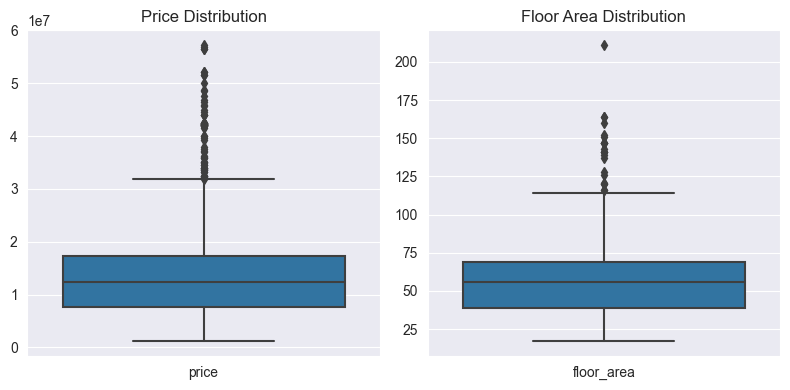

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.boxplot(data=df_condo[['price']], ax=ax[0])
ax[0].set_title('Price Distribution')

sns.boxplot(data=df_condo[['floor_area']], ax=ax[1])
ax[1].set_title('Floor Area Distribution')

plt.tight_layout()
plt.show()

## Heatmap

In [28]:
# Create a new DataFrame with the required columns
df_map = df_condo[['latitude', 'longitude', 'price', 'description', 'bedrooms']]

fig = px.density_mapbox(df_map, lat='latitude', lon='longitude', z='price',
                        custom_data=['description', 'bedrooms'],  # Add descriptions to customdata
                        zoom=10,
                        center=dict(lat=14.55554, lon=121.0901),
                        mapbox_style="stamen-terrain",
                        radius=25,
                        opacity=0.5)

# Customize the hover tooltip to show descriptions
fig.update_traces(
    hovertemplate='<b>Description:</b> %{customdata[0]}<br>'
                  '<b>Bedrooms:</b> %{customdata[1]}<br>'
                  '<b>Price:</b> %{z:,}<br>'
                  '<b>Latitude:</b> %{lat}<br>'
                  '<b>Longitude:</b> %{lon}',
    hoverinfo='text+z'
)

fig.update_layout(
    title_text='Philippines Heatmap of the Condo Prices',
    title_x=0.5,
    title_font=dict(size=32),
    coloraxis_showscale=True,  # Hide the color scale legend
    width=960,  # Adjust the width of the figure
    height=840  # Adjust the height of the figur
)

fig.show()

Mean price of the condos per city

In [29]:
df_city = (
    df_condo
    .groupby('city')
    .agg({'price': lambda x: int(x.mean()), 'floor_area': lambda x: int(x.mean()), 'city': 'count'})
    .rename(columns={'price': 'mean_price', 'floor_area': 'mean_floor_area', 'city': 'listing_count'})
    .reset_index()
)
df_city.sort_values('mean_price', ascending=False).head()

city  mean_price  mean_floor_area  listing_count
16      pasig    19588003               65            603
18   san juan    16173636               74             11
11    mandaue    13000000               72              2
22     taguig    11950000               40              2
8   lapu-lapu    10646902               49              5

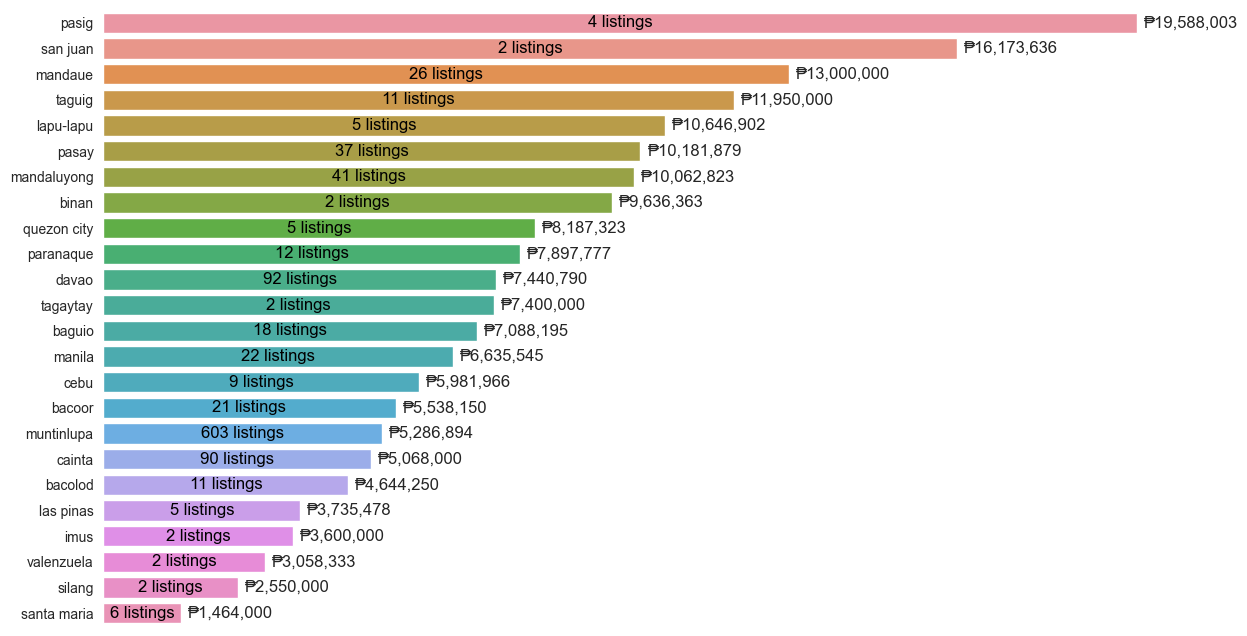

In [30]:
order = df_city.sort_values('mean_price', ascending=False)['city'].values

fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(data=df_city, x='mean_price', y='city', orient='h', order=order, ax=ax)

ax.set(
    ylabel='',
    xlabel=''
)

# Remove x-axis tick labels
ax.set_xticklabels([])

# Add value labels on top of each bar
for p in ax.containers:
    ax.bar_label(p, label_type='edge', padding=5, fontsize=12, labels=[f"₱{int(val):,}" for val in p.datavalues])

# Plot transaction count above each bar
for i, p in enumerate(ax.patches):
    # Calculate the x and y coordinates for the text
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() / 2

    # Format the listing count label
    label = f"{df_city['listing_count'][i]:,} listings"

    # Add the label inside the bar
    ax.annotate(label, (x, y), xytext=(0, 0), textcoords='offset points', va='center', ha='center', fontsize=12, color='black')

# Remove grid lines
ax.grid(False)

# Remove BG
ax.set_facecolor('none')

# Remove outer box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## Machine Learning

I'm just interested in condos, so I will filter the dataframe for condos only. Before we do modeling, let's make the price normal distribution by using np.log. Also let's make an inflated price.

For condominium units, prices rose strongly by 12.9% (4.4% inflation-adjusted) in 2022 from a year earlier. Yet quarter-on-quarter, condominium prices dropped 4.9% (-6.9% inflation-adjusted) in Q4.

In [31]:
growth_rate = 6.9
df_copy['inflated_price'] = (df_copy['price'] * (1 + growth_rate / 100)).round().astype(int)

# Apply np.log transformation to the target variable 'price'
df_copy['log_price'] = np.log(df_copy['price'])
df_copy['log_inflated_price'] = np.log(df_copy['inflated_price'])

In [32]:
df_copy.head()

description  \
0  2-Bedroom Unit for Sale in Amisa Private Resid...   
1  1-Bedroom Unit for Sale in Amisa Private Resid...   
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
4  Alice 2 Storey Townhouse For Sale in Lancaster...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   

                     location     price  bedrooms  floor_area   latitude  \
0           Mactan, Lapu-Lapu  15916180         2          74  10.305155   
1           Mactan, Lapu-Lapu   8730355         1          41  10.305155   
3                Ugong, Pasig  16011000         1          58  14.588882   
4        Tapia, General Trias   1935600         3          40  14.355070   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   

    longitude  inflated_price  log_price  log_inflated_price  
0  124.011241        17014396  16.582847           16.649570  
1  124.011241         9332749  15.982317           16.049040  
3  121.079016        17115759  16.588787           16.655510  
4  120.876425         2069156  14.475928           14.542651  
5  121.052143         8110517  15.841949           15.908672

In [33]:
df_copy.shape

(1326, 10)

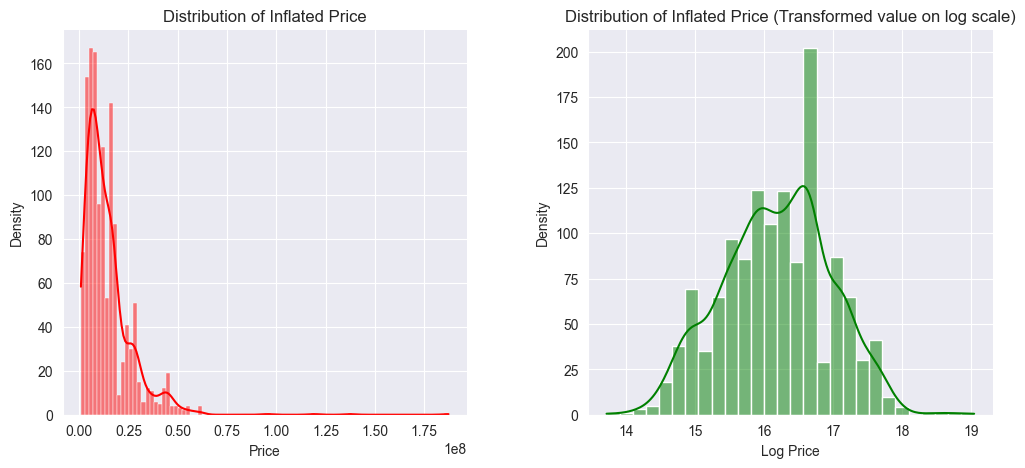

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjusted figsize for better visualization

# Plotting the first subplot
sns.histplot(df_copy.inflated_price, ax=ax[0], kde=True, color='red')
ax[0].set_title('Distribution of Inflated Price')
ax[0].set_xlabel("Price")
ax[0].set_ylabel('Density')

# Plotting the second subplot with log-transformed price
sns.histplot(df_copy.log_inflated_price, ax=ax[1], kde=True, color='green')
ax[1].set_title('Distribution of Inflated Price (Transformed value on log scale)')
ax[1].set_xlabel("Log Price")
ax[1].set_ylabel('Density')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.3)

# Apply grid and remove spines
sns.despine()

plt.show()

In [35]:
train_df = df_copy.query(
    'description.str.lower().str.contains("condo|studio|unit|pre-selling") & location.str.lower().str.contains("pasig|mandaluyong|quezon city")'
).copy()
train_df.head()

description  \
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   
6  Studio Deluxe (43E) for Sale in Empress at Cap...   
7  1-Bedroom Unit (1918) for Sale in Maple at Ver...   
8  1-Bedroom Unit (21J) - Residences at The Galle...   

                     location     price  bedrooms  floor_area   latitude  \
3                Ugong, Pasig  16011000         1          58  14.588882   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   
6               Oranbo, Pasig  13246000         1          46  14.575822   
7                Ugong, Pasig  15492000         1          56  14.588882   
8          San Antonio, Pasig  26930000         1          70  14.588377   

    longitude  inflated_price  log_price  log_inflated_price  
3  121.079016        17115759  16.588787           16.655510  
5  121.052143         8110517  15.841949           15.908672  
6  121.064324        14159974  16.399206           16.465930  
7  121.079016        16560948  16.555834           16.622558  
8  121.059897        28788170  17.108751           17.175475

In [36]:
train_df.shape

(788, 10)

In [37]:
train_df.location.value_counts().sort_values(ascending=False).head()

Ugong, Pasig                  246
Ortigas CBD, Pasig            143
Oranbo, Pasig                 140
Highway Hills, Mandaluyong     70
San Antonio, Pasig             63
Name: location, dtype: int64

In [38]:
train_df.columns

Index(['description', 'location', 'price', 'bedrooms', 'floor_area',
       'latitude', 'longitude', 'inflated_price', 'log_price',
       'log_inflated_price'],
      dtype='object')

In [39]:
cols_to_plot = train_df.loc[:, ~train_df.columns.isin([
    'description', 'location', 'latitude', 'longitude', 'bedrooms'
])]

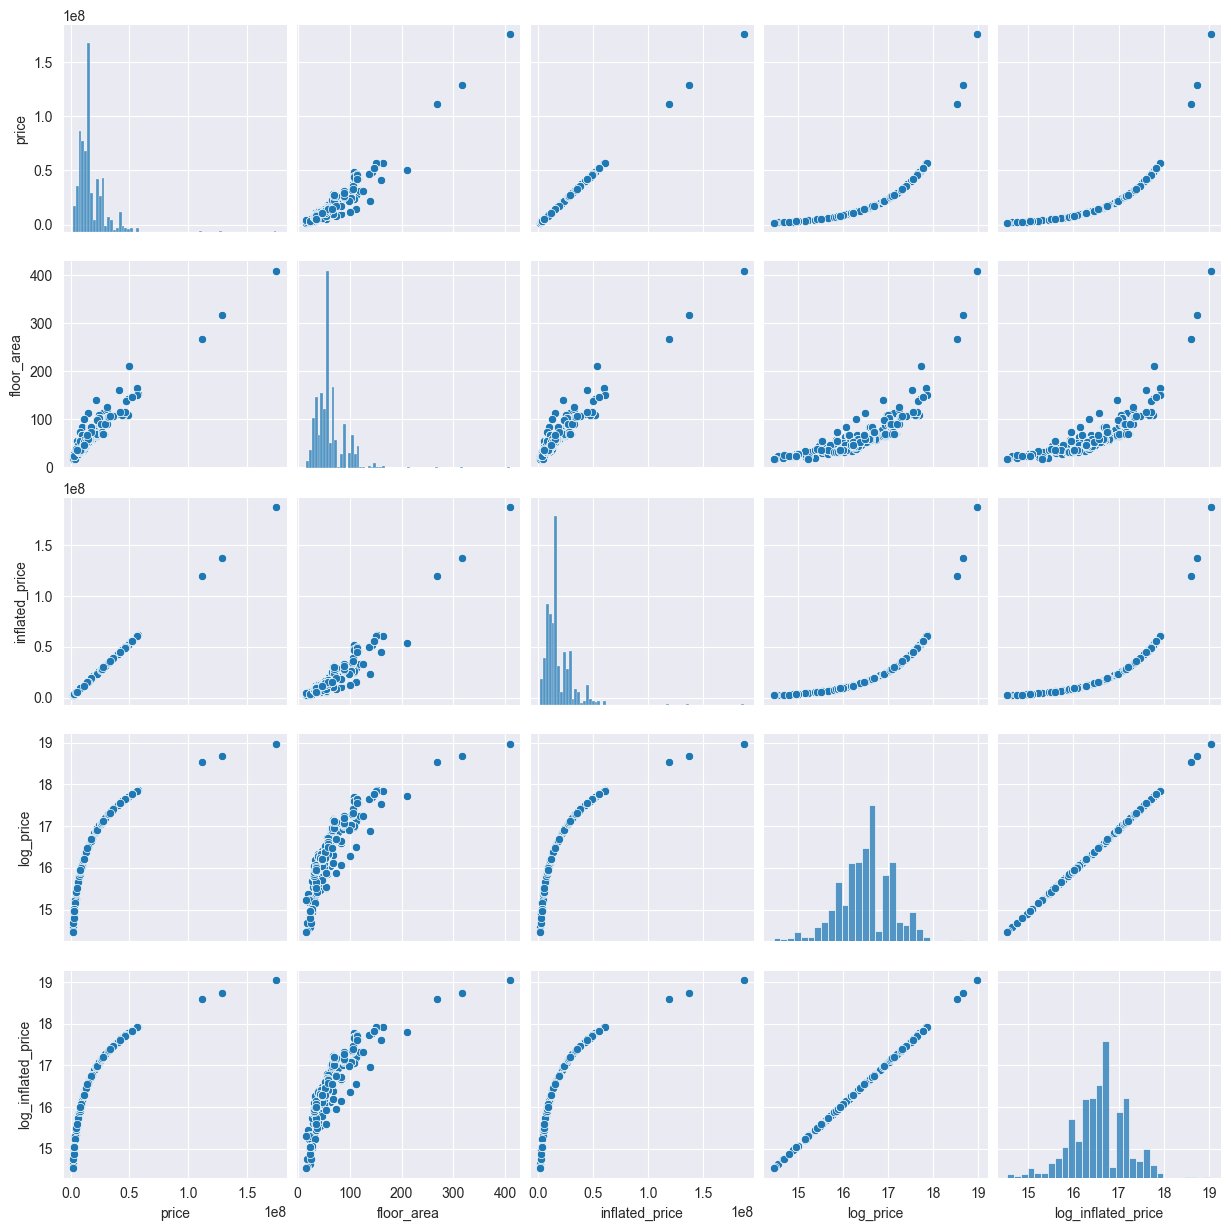

In [40]:
sns.pairplot(data=cols_to_plot);

Let's check for correlation

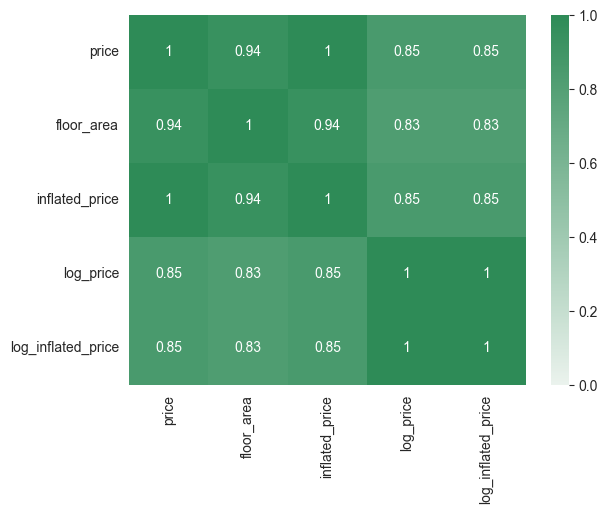

In [41]:
sns.heatmap(
    data=cols_to_plot.corr(), 
    vmin=0, 
    vmax=1, 
    annot=True, 
    cmap=sns.light_palette("seagreen", as_cmap=True)
);

## Linear model

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming train_df is your DataFrame

# Save X and y data into variables
X = train_df[["floor_area"]]
y = train_df["log_inflated_price"]

# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('model', LinearRegression())
])

# Fit the pipeline to the data
model = pipe.fit(X_train, y_train)

In [43]:
intercept = model.named_steps['model'].intercept_
coefficients = model.named_steps['model'].coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 15.44213590619739
Coefficients: [0.01811657]


For every one unit increase in the floor_area (X), on average, the price (y) is expected to increase by coeff.

In [44]:
model.score(X, y) # R-squared

0.6724902827541563

67.25% of the variation is explained by its size. While the rest can be attributed by error.

In [45]:
# Predictions from the model
y_test_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_test_pred

### Linear Regression Assumptions

Linearity

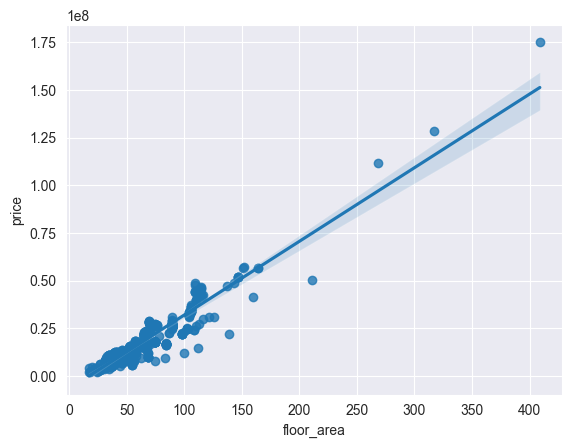

In [46]:
sns.regplot(x='floor_area', y='price', data=train_df);

Residuals

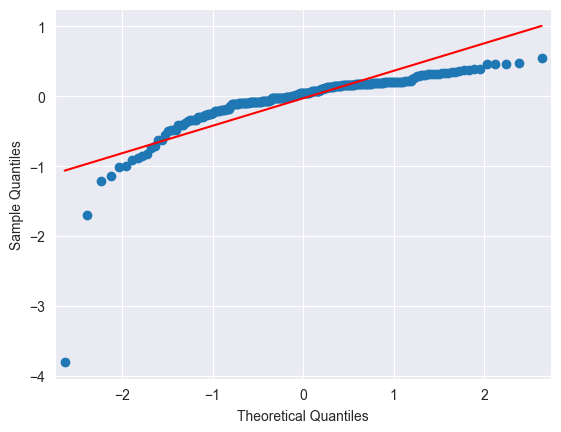

In [47]:
import statsmodels.api as sm

fig = sm.qqplot(residuals, line='s')
plt.show()

Distribution

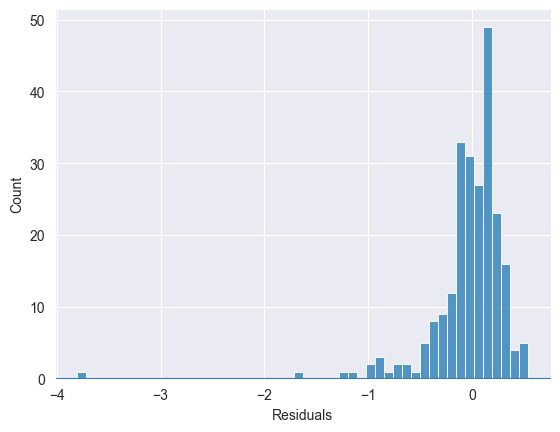

In [48]:
fig = sns.histplot(residuals)
fig.axhline(0)
fig.set_xlabel('Residuals')
plt.show()

Homoscedasticity

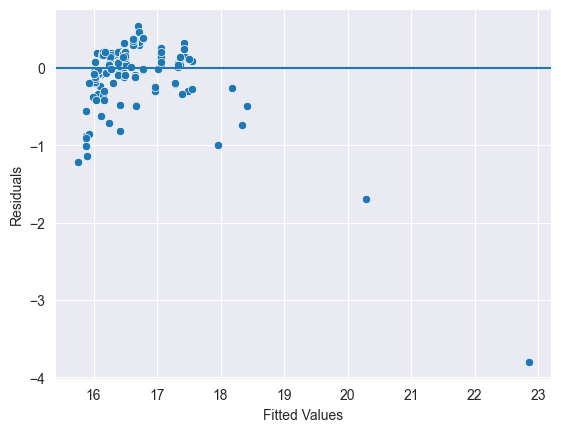

In [49]:
fig = sns.scatterplot(x=y_test_pred, y=residuals)
fig.axhline(0)
fig.set_xlabel('Fitted Values')
fig.set_ylabel('Residuals')
plt.show()

### Testing linear model

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE Train: {mae_train:,.2f}")
print(f"MAE Test: {mae_test:,.2f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE Train: {rmse_train:,.2f}")
print(f"RMSE Test: {rmse_test:,.2f}")

MAE Train: 0.23
MAE Test: 0.23
RMSE Train: 0.32
RMSE Test: 0.39


Our model's predictions on the training data deviate from the actual values by an average of 0.23.

Checking our predicted price vs actual price

In [51]:
# Create a new DataFrame with original floor_area, actual prices, and predicted prices
predicted_df = pd.DataFrame({
    'floor_area': X_test.floor_area,
    'price': np.exp(y_test).round().astype(int),
    'predicted_price': np.exp(y_test_pred).round().astype('int64')
})

predicted_df.sort_values('price', ascending=False).sample(5, random_state=16)

floor_area      price  predicted_price
781           58   17234418         14547028
1042          45   13231013         11494529
858           32    7910600          9082557
386          409  187358285       8402667243
1180          70   28810619         18079625

In [52]:
test_data_score = model.score(X_test, y_test) * 100
entire_data_score = model.score(X, y) * 100
trained_data_score = model.score(X_train, y_train) * 100
print(
    f"""
    Entire Data Score: {entire_data_score:.2f}
    Test Data Score: {test_data_score:.2f}
    Trained Data Score: {trained_data_score:.2f}
    """
)


    Entire Data Score: 67.25
    Test Data Score: 56.78
    Trained Data Score: 71.75
    


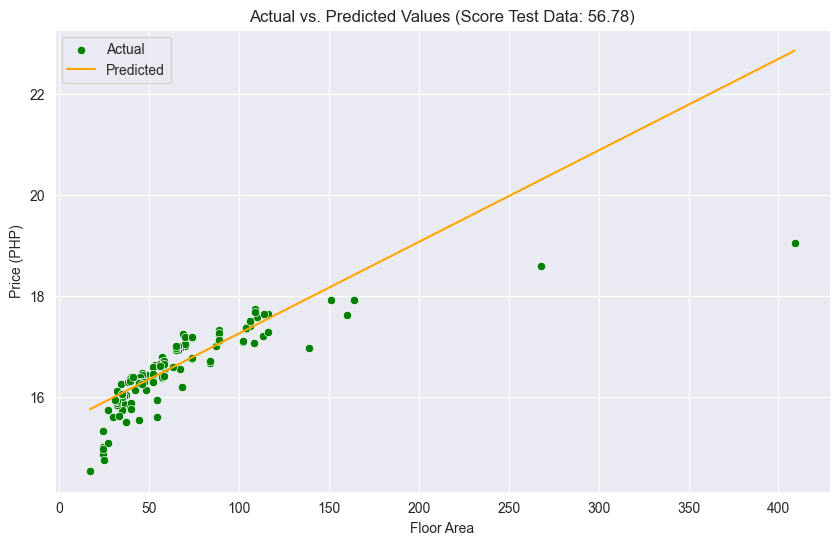

In [53]:
# Predictions from the model on the test data
y_test_pred = model.predict(X_test)

# Create a scatter plot for actual vs. predicted values using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.floor_area, y=y_test, color='green', label='Actual')
sns.lineplot(x=X_test.floor_area, y=y_test_pred, color='orange', label='Predicted')
plt.xlabel("Floor Area")
plt.ylabel("Price (PHP)")
plt.title(f"Actual vs. Predicted Values (Score Test Data: {model.score(X_test, y_test) * 100:.2f})")
plt.legend()
plt.show()

56.78% of the variation is explained by its size. While the rest can be attributed by error.

Testing new condo listings in Pasig using the Lamudi platform.

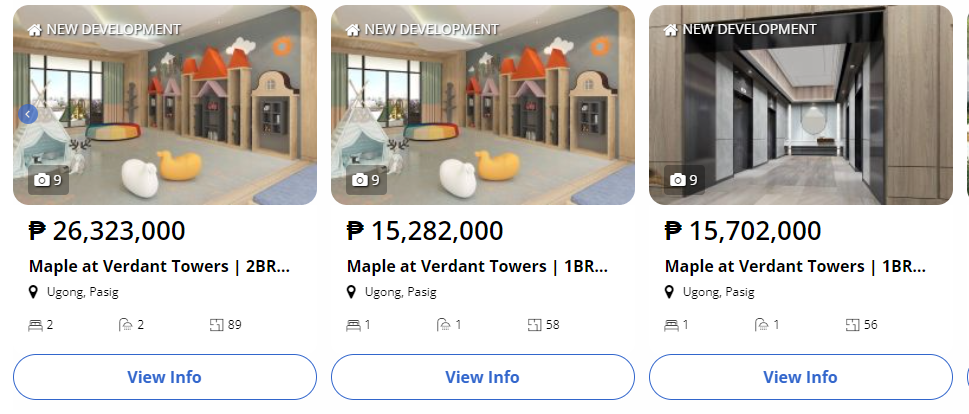

In [54]:
lamudi_new_listing = [[89], [58], [56]]
new_data = pd.DataFrame(lamudi_new_listing, columns=['floor_area'])

# Predict prices for the new data
y_new_pred = model.predict(new_data)

for i, predicted_price in enumerate(y_new_pred):
    predicted_price = np.exp(predicted_price)
    square_meter = lamudi_new_listing[i][0]
    
    print(f"Floor Area (square meter): {square_meter}")
    print(f"Predicted Price: {int(predicted_price):,}")
    print()

Floor Area (square meter): 89
Predicted Price: 25,508,213

Floor Area (square meter): 58
Predicted Price: 14,547,027

Floor Area (square meter): 56
Predicted Price: 14,029,377



**Plotting learning curves**

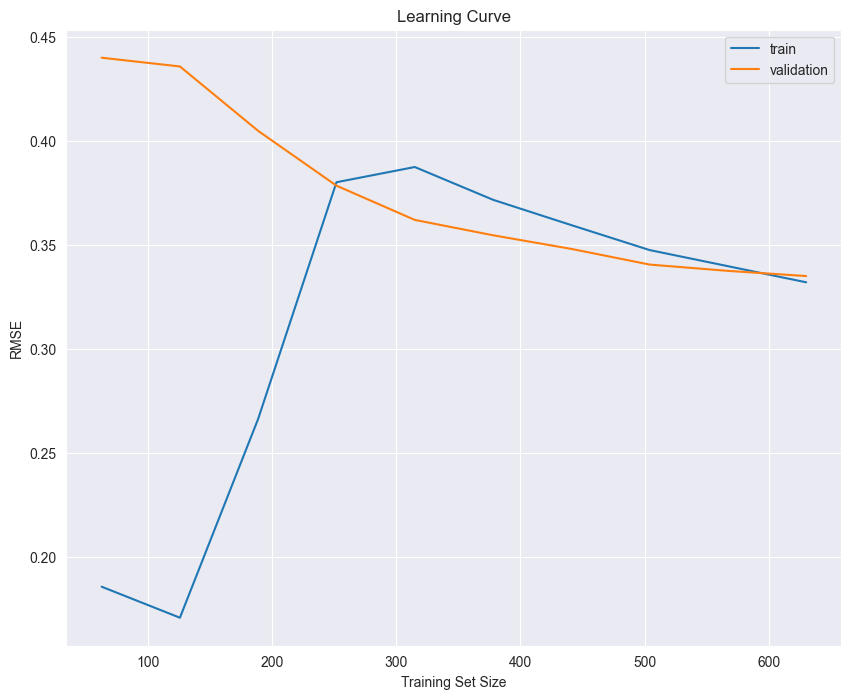

In [55]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

As the size of the training set grows, we observe an uptick in our training loss while the validation loss shows only marginal decline. This pattern suggests potential underfitting or limited learning by the current model. Exploring alternative models for training could be beneficial.

## Random Forest Model

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Save X and y data into variables
X = train_df[["floor_area", "bedrooms"]]
y = train_df["log_inflated_price"]

# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Fit the pipeline to the data
param_grid = {
    'model__n_estimators': np.arange(600, 1000, 200),
    'model__max_depth': [25, 75, 25],
    'model__min_samples_split': [2, 100, 50],
}

grid_search = GridSearchCV(n_jobs=2, estimator=pipe, param_grid=param_grid, scoring='r2', cv=5, return_train_score=True)
forest = grid_search.fit(X_train, y_train)

In [57]:
best_estimator = forest.best_estimator_
best_estimator

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=75, n_estimators=800))])

In [58]:
forest.score(X_test, y_test) * 100, forest.score(X, y) * 100

(95.12673242165178, 96.70175838985972)

In [59]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE Train: {mae_train:,.2f}")
print(f"MAE Test: {mae_test:,.2f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE Train: {rmse_train:,.2f}")
print(f"RMSE Test: {rmse_test:,.2f}")

MAE Train: 0.05
MAE Test: 0.07
RMSE Train: 0.10
RMSE Test: 0.13


In [60]:
# Create a new DataFrame with original floor_area, bedrooms, actual prices, and predicted prices
predicted_df = pd.DataFrame({
    'floor_area': X_test.floor_area,
    'bedrooms': X_test.bedrooms,
    'price': np.exp(y_test).round().astype('int64'),
    'predicted_price': np.exp(y_test_pred).round().astype('int64')
})
predicted_df.sort_values('price', ascending=False).sample(5, random_state=16)

floor_area  bedrooms      price  predicted_price
781           58         1   17234418         16882374
1042          45         1   13231013         13344597
858           32         1    7910600          7609302
386          409         4  187358285         99751534
1180          70         1   28810619         27528854

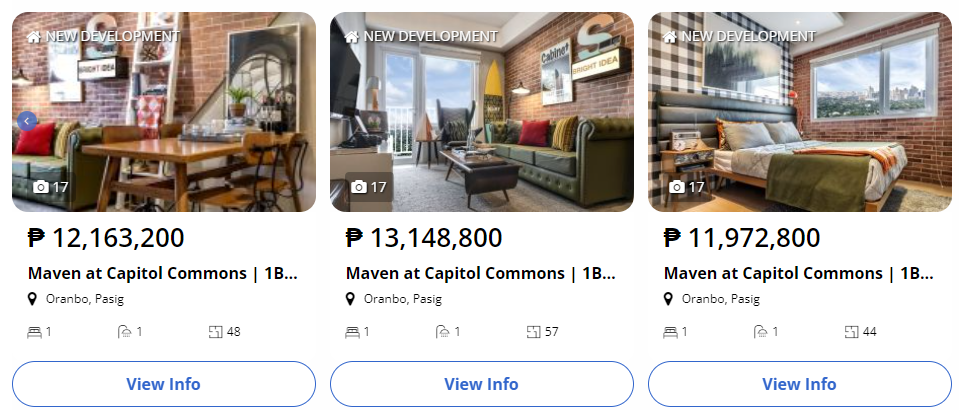

In [61]:
lamudi_new_listing = np.array([[48, 1], [57, 1], [44, 1]])

# Create a DataFrame for new data with the same feature names
new_data_df = pd.DataFrame(lamudi_new_listing, columns=["floor_area", "bedrooms"])

# Predict prices for the new data using the trained forest_regressor
y_new_pred = forest.predict(new_data_df)

for i, predicted_price in enumerate(y_new_pred):
    predicted_price = np.exp(predicted_price)
    square_meter = lamudi_new_listing[i][0]
    
    print(f"Floor Area (square meter): {square_meter}")
    print(f"Predicted Price: {int(predicted_price):,}")
    print()

Floor Area (square meter): 48
Predicted Price: 12,141,132

Floor Area (square meter): 57
Predicted Price: 16,480,270

Floor Area (square meter): 44
Predicted Price: 11,911,133



This is kinda okay just a little bit off at floor area 57.

**Plotting Learning Curves**

Loading takes time so I'll just use the settings above to plot this.

In [62]:
# Save X and y data into variables
X = train_df[["floor_area", "bedrooms"]]
y = train_df["log_inflated_price"]

# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', best_estimator.named_steps['model'])
])

forest = pipe.fit(X_train, y_train)
forest.score(X_test, y_test), forest.score(X, y)

(0.9513609522813024, 0.9671844388731781)

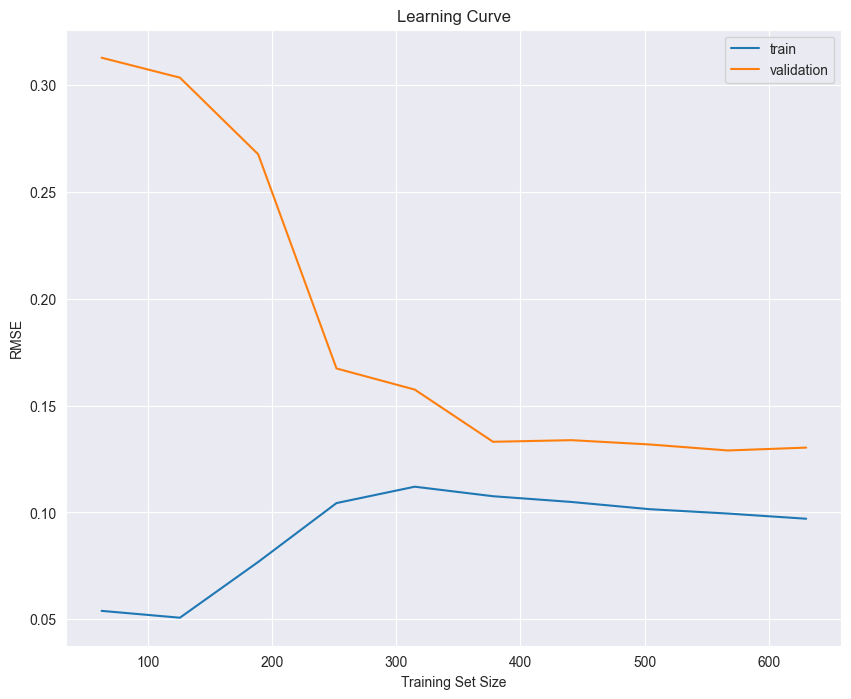

In [63]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=forest,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=2
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

As training set size increases, a lower negative RMSE on the graph means better performance and reduced actual error. The RandomForestRegressor consistently minimizes errors by learning from data. Notably, this model significantly outperforms the linear regression with lower error. To improve further, we can add new features and reapply RandomForestRegressor to enhance the learning curve and predictions.

## Adding new features

In [64]:
new_train_df = df_copy.query(
    'description.str.lower().str.contains("condo|studio|unit|pre-selling") & location.str.lower().str.contains("pasig|mandaluyong|quezon city")'
).copy()
new_train_df.head()

description  \
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   
6  Studio Deluxe (43E) for Sale in Empress at Cap...   
7  1-Bedroom Unit (1918) for Sale in Maple at Ver...   
8  1-Bedroom Unit (21J) - Residences at The Galle...   

                     location     price  bedrooms  floor_area   latitude  \
3                Ugong, Pasig  16011000         1          58  14.588882   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   
6               Oranbo, Pasig  13246000         1          46  14.575822   
7                Ugong, Pasig  15492000         1          56  14.588882   
8          San Antonio, Pasig  26930000         1          70  14.588377   

    longitude  inflated_price  log_price  log_inflated_price  
3  121.079016        17115759  16.588787           16.655510  
5  121.052143         8110517  15.841949           15.908672  
6  121.064324        14159974  16.399206           16.465930  
7  121.079016        16560948  16.555834           16.622558  
8  121.059897        28788170  17.108751           17.175475

We're going to try something new: generating additional features from property descriptions. I think including the building's name might make condo prices more impactful. The better-known the building, the higher the price tends to be.

In [65]:
new_train_df.description.value_counts()

2BR Condo Unit for Sale in Ibiza Tower at Circulo Verde, Bagumbayan, Quezon City | Un...    12
1BR Condo Unit for Sale in Seville Residences at Circulo Verde, Bagumbayan, Quezon Ci...     6
1 bedroom Condominium for Sale in Suntrust Capitol Plaza, Diliman, Quezon City               3
Condominium with 3 bedroom for Sale in Suntrust Shanata, Novaliches, Quezon City             3
Condominium with 2 bedroom for Sale in Suntrust Shanata, Novaliches, Quezon City             3
                                                                                            ..
Pre-selling Studio Unit (30 sqm) in Aurora Escalades, Cubao Quezon City                      1
Studio Condo Unit (29E) for Sale in One Sierra, EDSA, Mandaluyong City, Metro Manila         1
2BR Unit for Sale in Suntrust Amadea Tower 2, Quezon City, 5.5M                              1
Pre-Selling 1BR (78.96 sqm) at The Residences At The Westin Manila Sonata Place              1
1-Bedroom Unit (S39D1) for Sale in Maven at Capito

Most of the text pattern shows the condo building name after "at" or "in", so let's make a regex that takes the word after "at" or "in".

In [66]:
# Function to extract condominium name using the patterns
def extract_condominium(text):
    at_pattern = r"at\s(.*?)(?=\s*\(|,|$)"
    in_pattern = r"in\s(.*?)(?=\s*\(|,|$)"

    matches_at = re.findall(at_pattern, text)
    matches_in = re.findall(in_pattern, text)

    if matches_at:
        return matches_at[0]
    elif matches_in:
        return matches_in[0]
    else:
        return None

In [67]:
new_train_df['condominium'] = new_train_df['description'].apply(extract_condominium)
new_train_df.value_counts('condominium')

condominium
Capitol Commons                            274
Verdant Towers                             246
One Sierra                                  64
The Galleon                                 63
Circulo Verde                               18
                                          ... 
Acqua Private Residences                     1
Suntrust Asmara Tower 2                      1
Circulo Verde in Bagumbayan Quezon City      1
Manila Sonata Place                          1
A. Bonifacio Quezon City. Php 95             1
Length: 43, dtype: int64

Let's clean it up a bit.

In [68]:
value = {
        r'Suntrust Amadea.*': 'Suntrust Amadea',
        r'Suntrust Asmara.*': 'Suntrust Asmara',
        r'The Residences.*': 'Residences',
        r'AMA Tower Residences.*': 'AMA Tower',
        r'Acacia Escalades.*': 'Acacia Escalades',
        r'Axis Residences.*': 'Axis Residences',
        r'The Sapphire Bloc.*': 'Sapphire Bloc',
        r'SYNC.*': 'SYNC Tower',
        r'Circulo Verde.*': 'Circulo Verde'
}
new_train_df['condominium'] = new_train_df['condominium'].replace(value,regex=True)
new_train_df.condominium.value_counts()

Capitol Commons                     274
Verdant Towers                      246
One Sierra                           64
The Galleon                          63
Circulo Verde                        19
                                   ... 
New Manila                            2
A. Bonifacio Quezon City. Php 95      1
Manila Sonata Place                   1
Acqua Private Residences              1
New Manila QC                         1
Name: condominium, Length: 30, dtype: int64

Now it's a bit clean, we'll remove those values that we didn't get in our regex.

In [69]:
new_train_df = new_train_df[~new_train_df['condominium'].str.lower().str.contains('city|manila|diliman|novaliches|mandaluyong')]
new_train_df.condominium.value_counts()

Capitol Commons             274
Verdant Towers              246
One Sierra                   64
The Galleon                  63
Circulo Verde                19
                           ... 
Axis Residences               2
Aurora Escalades              2
SYNC Tower                    2
Gateway Regency Studios       2
Acqua Private Residences      1
Name: condominium, Length: 20, dtype: int64

In [70]:
# Lowercase and replace the whitespace with _
new_train_df['condominium'] = new_train_df['condominium'].str.lower().str.replace(' ', '_')
new_train_df.head()

description  \
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   
6  Studio Deluxe (43E) for Sale in Empress at Cap...   
7  1-Bedroom Unit (1918) for Sale in Maple at Ver...   
8  1-Bedroom Unit (21J) - Residences at The Galle...   

                     location     price  bedrooms  floor_area   latitude  \
3                Ugong, Pasig  16011000         1          58  14.588882   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   
6               Oranbo, Pasig  13246000         1          46  14.575822   
7                Ugong, Pasig  15492000         1          56  14.588882   
8          San Antonio, Pasig  26930000         1          70  14.588377   

    longitude  inflated_price  log_price  log_inflated_price      condominium  
3  121.079016        17115759  16.588787           16.655510   verdant_towers  
5  121.052143         8110517  15.841949           15.908672       one_sierra  
6  121.064324        14159974  16.399206           16.465930  capitol_commons  
7  121.079016        16560948  16.555834           16.622558   verdant_towers  
8  121.059897        28788170  17.108751           17.175475      the_galleon

This looks good! We'll make the condo binary by using pd.dummies so we can put it in our model.

In [71]:
district_dummies = pd.get_dummies(new_train_df['condominium'])

# Concatenate the dummy variables back to the DataFrame
new_train_df = pd.concat([new_train_df, district_dummies,], axis=1)
new_train_df.head()

description  \
3  1-Bedroom Unit (821) for Sale in Maple at Verd...   
5  Studio Condo Unit (6B) for Sale in One Sierra,...   
6  Studio Deluxe (43E) for Sale in Empress at Cap...   
7  1-Bedroom Unit (1918) for Sale in Maple at Ver...   
8  1-Bedroom Unit (21J) - Residences at The Galle...   

                     location     price  bedrooms  floor_area   latitude  \
3                Ugong, Pasig  16011000         1          58  14.588882   
5  Highway Hills, Mandaluyong   7587013         1          32  14.578255   
6               Oranbo, Pasig  13246000         1          46  14.575822   
7                Ugong, Pasig  15492000         1          56  14.588882   
8          San Antonio, Pasig  26930000         1          70  14.588377   

    longitude  inflated_price  log_price  log_inflated_price      condominium  \
3  121.079016        17115759  16.588787           16.655510   verdant_towers   
5  121.052143         8110517  15.841949           15.908672       one_sierra   
6  121.064324        14159974  16.399206           16.465930  capitol_commons   
7  121.079016        16560948  16.555834           16.622558   verdant_towers   
8  121.059897        28788170  17.108751           17.175475      the_galleon   

   acacia_escalades  acqua_private_residences  ama_tower  aurora_escalades  \
3                 0                         0          0                 0   
5                 0                         0          0                 0   
6                 0                         0          0                 0   
7                 0                         0          0                 0   
8                 0                         0          0                 0   

   axis_residences  capitol_commons  circulo_verde  gateway_regency_studios  \
3                0                0              0                        0   
5                0                0              0                        0   
6                0                1              0                        0   
7                0                0              0                        0   
8                0                0              0                        0   

   one_sierra  residences  sapphire_bloc  suntrust_amadea  suntrust_asmara  \
3           0           0              0                0                0   
5           1           0              0                0                0   
6           0           0              0                0                0   
7           0           0              0                0                0   
8           0           0              0                0                0   

   suntrust_capitol_plaza  suntrust_kirana  suntrust_shanata  sync_tower  \
3                       0                0                 0           0   
5                       0                0                 0           0   
6                       0                0                 0           0   
7                       0                0                 0           0   
8                       0                0                 0           0   

   the_galleon  the_signature  verdant_towers  
3            0              0               1  
5            0              0               0  
6            0              0               0  
7            0              0               1  
8            1              0               0

In [72]:
new_train_df.shape

(756, 31)

In [73]:
new_train_df.columns

Index(['description', 'location', 'price', 'bedrooms', 'floor_area',
       'latitude', 'longitude', 'inflated_price', 'log_price',
       'log_inflated_price', 'condominium', 'acacia_escalades',
       'acqua_private_residences', 'ama_tower', 'aurora_escalades',
       'axis_residences', 'capitol_commons', 'circulo_verde',
       'gateway_regency_studios', 'one_sierra', 'residences', 'sapphire_bloc',
       'suntrust_amadea', 'suntrust_asmara', 'suntrust_capitol_plaza',
       'suntrust_kirana', 'suntrust_shanata', 'sync_tower', 'the_galleon',
       'the_signature', 'verdant_towers'],
      dtype='object')

Correlation

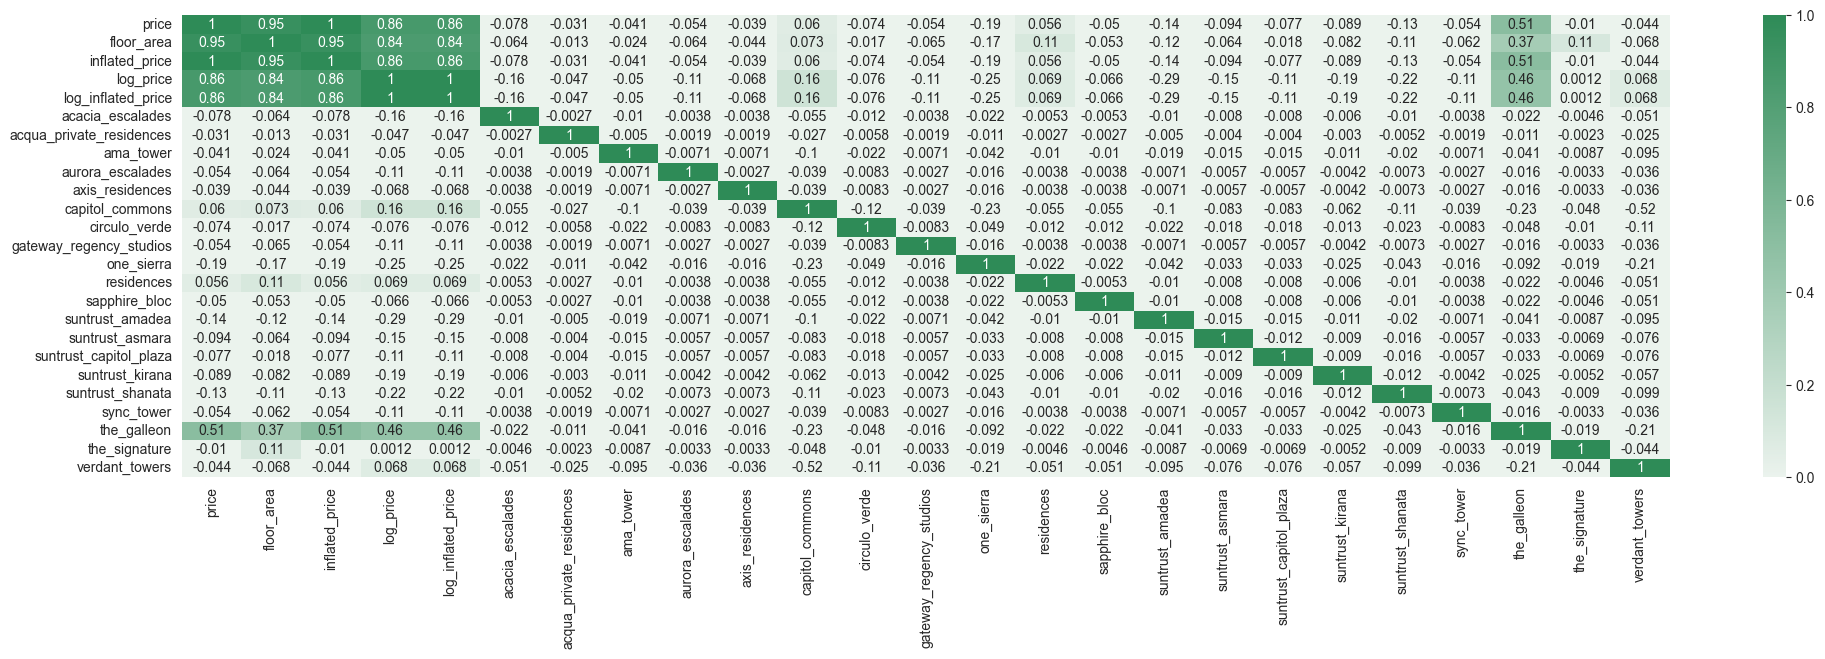

In [74]:
cols_to_plot = new_train_df.loc[:, ~new_train_df.columns.isin([
    'description', 'location', 'latitude', 'longitude', 'bedrooms'
])]

plt.figure(figsize=(24, 6))
sns.heatmap(
    data=cols_to_plot.corr(numeric_only=True), 
    vmin=0, 
    vmax=1, 
    annot=True, 
    cmap=sns.light_palette("seagreen", as_cmap=True)
);

Let's add the new features to our model.

In [75]:
# Select all columns except for the ones that we don't need in X
new_train_df.loc[:, ~new_train_df.columns.isin(
    ['description', 'inflated_price', 'condominium', 'price', 'latitude', 'longitude', 
     'location', 'log_price', 'log_inflated_price']
)].columns

Index(['bedrooms', 'floor_area', 'acacia_escalades',
       'acqua_private_residences', 'ama_tower', 'aurora_escalades',
       'axis_residences', 'capitol_commons', 'circulo_verde',
       'gateway_regency_studios', 'one_sierra', 'residences', 'sapphire_bloc',
       'suntrust_amadea', 'suntrust_asmara', 'suntrust_capitol_plaza',
       'suntrust_kirana', 'suntrust_shanata', 'sync_tower', 'the_galleon',
       'the_signature', 'verdant_towers'],
      dtype='object')

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Save X and y data into variables
X = new_train_df.loc[:, ~new_train_df.columns.isin(
    ['description', 'inflated_price', 'condominium', 'price', 'latitude', 'longitude', 
     'location', 'log_price', 'log_inflated_price']
)]
y = new_train_df["log_inflated_price"]

# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Fit the pipeline to the data
param_grid = {
    'model__n_estimators': np.arange(100, 1500, 200),
    'model__max_depth': [None, 50, 75, 100]
}

grid_search = GridSearchCV(n_jobs=2, estimator=pipe, param_grid=param_grid, scoring='r2', cv=5, return_train_score=True)
forest = grid_search.fit(X_train, y_train)

In [77]:
best_estimator = forest.best_estimator_
best_estimator

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=50, n_estimators=900))])

In [78]:
forest.score(X_test, y_test), forest.score(X, y)

(0.9817862439074022, 0.9899360263131539)

In [79]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE Train: {mae_train:,.2f}")
print(f"MAE Test: {mae_test:,.2f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE Train: {rmse_train:,.2f}")
print(f"RMSE Test: {rmse_test:,.2f}")

MAE Train: 0.03
MAE Test: 0.04
RMSE Train: 0.05
RMSE Test: 0.07


Our score and errors looks better here than our first model. That's a good sign that our features did something.

In [80]:
# Create a new DataFrame with original floor_area, bedrooms, actual prices, and predicted prices
predicted_df = pd.DataFrame({
    'floor_area': X_test.floor_area,
    'bedrooms': X_test.bedrooms,   
    'price': np.exp(y_test).round().astype('int64'),
    'predicted_price': np.exp(y_test_pred).round().astype('int64')
})

predicted_df.sort_values('price', ascending=False).sample(5, random_state=16)

floor_area  bedrooms      price  predicted_price
1148          59         1   15472920         15537547
178           39         1   12670857         12541455
1052         114         2   45224045         45692148
386          409         4  187358285         90095843
1336          58         1   17458908         17137545

The loading time is too long, so what will I do is just use the settings that the CVsearch recommended.

In [81]:
# Save X and y data into variables
X = new_train_df.loc[:, ~new_train_df.columns.isin(
    ['description', 'inflated_price', 'condominium', 'price', 'latitude', 'longitude', 
     'location', 'log_price', 'log_inflated_price']
)]
y = new_train_df["log_inflated_price"]

# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', best_estimator.named_steps['model'])
])

forest = pipe.fit(X_train, y_train)
forest.score(X_test, y_test), forest.score(X, y)

(0.9812989086049551, 0.9898919015226549)

In [82]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE Train: {mae_train:,.2f}")
print(f"MAE Test: {mae_test:,.2f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE Train: {rmse_train:,.2f}")
print(f"RMSE Test: {rmse_test:,.2f}")

MAE Train: 0.03
MAE Test: 0.04
RMSE Train: 0.05
RMSE Test: 0.08


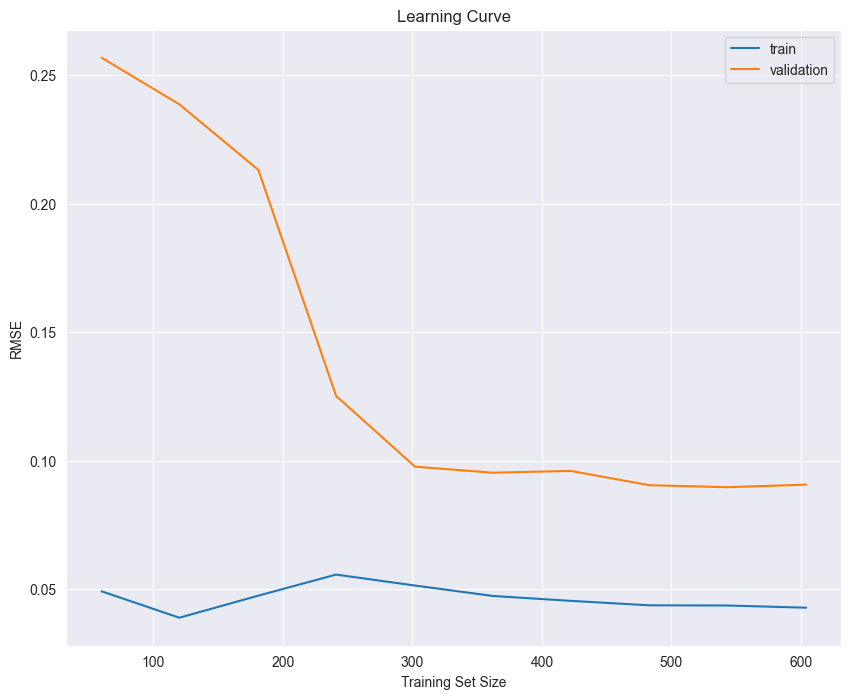

In [83]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=forest,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=2
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

Our updated random forest regression model demonstrates improved performance compared to the previous version. It exhibits reduced error when compared to the earlier model that lacked supplementary features. Notably, the learning curve displays a decline in both training and validation losses as the size of the training set increases. This pattern suggests that providing the model with more data has the potential to further minimize training and validation losses, solidifying the model's effectiveness.

Testing it with actual price in Lamudi.

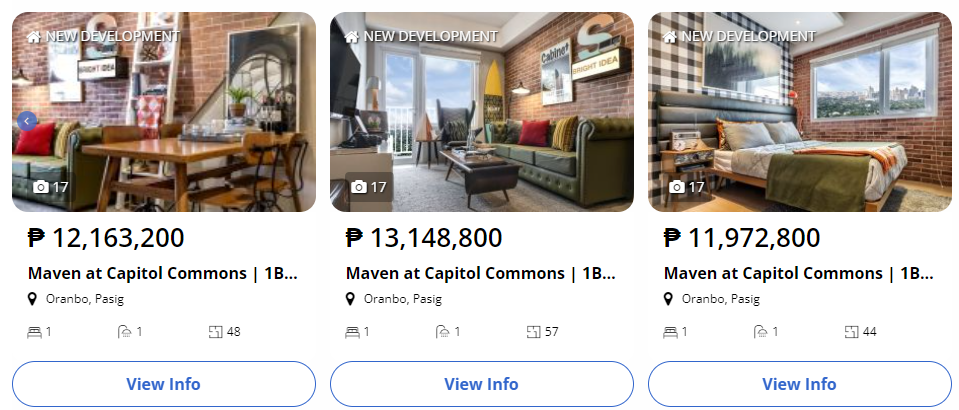
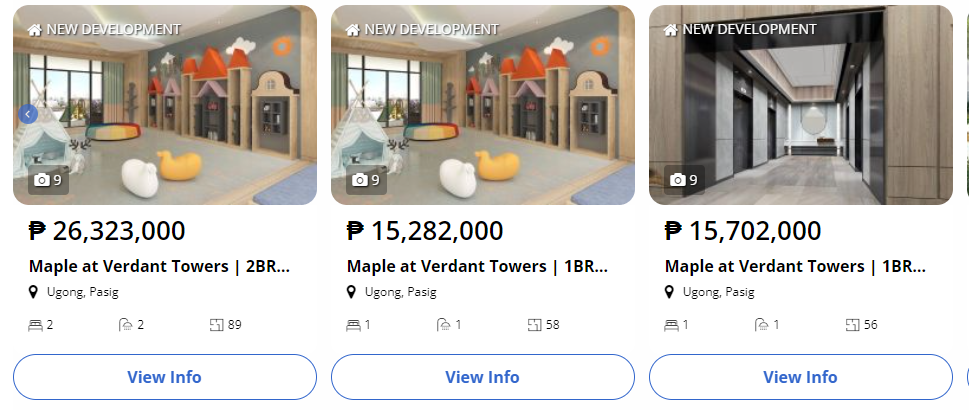
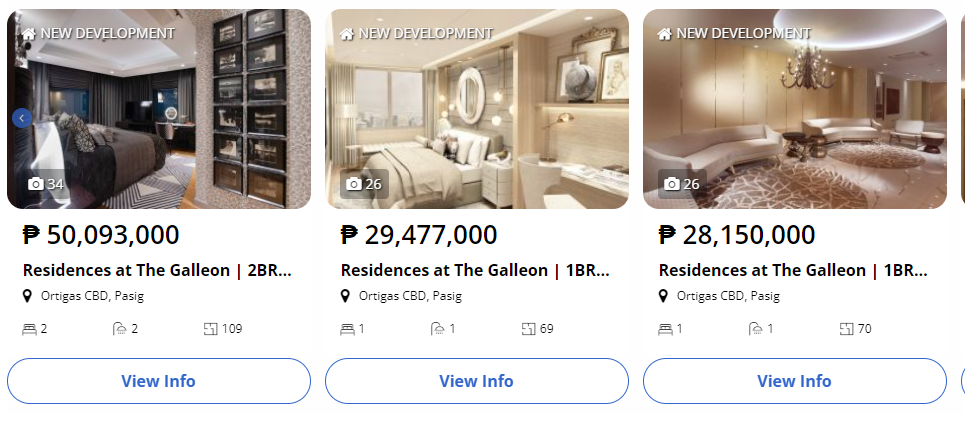
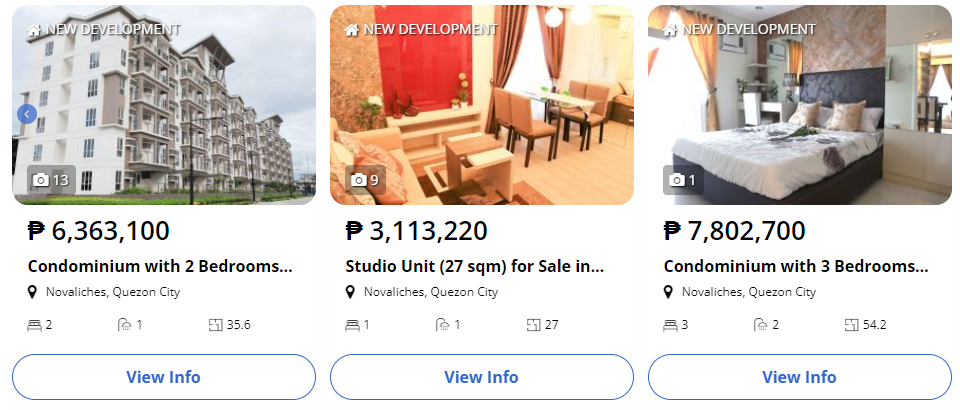
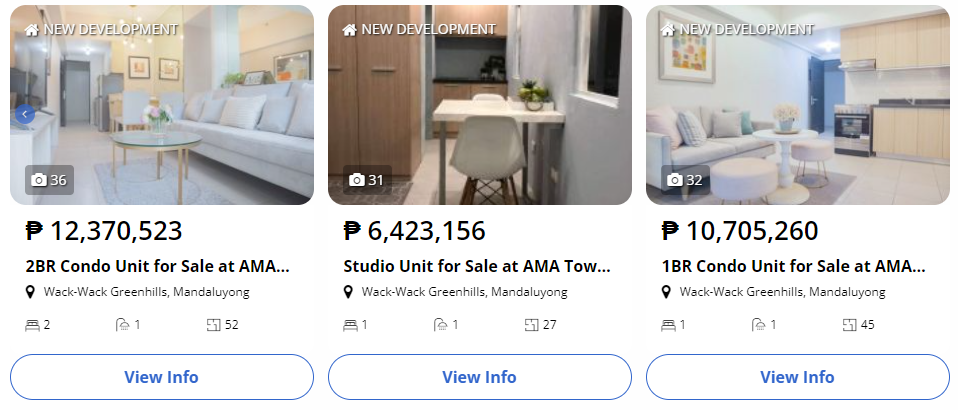

In [84]:
# List of condominium names
condo_data = {
    'acacia_escalades': [{'bedrooms': 0, 'floor_area': 0}],
    'acqua_private_residences': [{'bedrooms': 0, 'floor_area': 0}],
    'ama_tower': [
        {'bedrooms': 2, 'floor_area': 52},
        {'bedrooms': 1, 'floor_area': 27},
        {'bedrooms': 1, 'floor_area': 45}
    ],
    'aurora_escalades': [{'bedrooms': 0, 'floor_area': 0}],
    'axis_residences': [{'bedrooms': 0, 'floor_area': 0}],
    'capitol_commons': [
        {'bedrooms': 1, 'floor_area': 48},
        {'bedrooms': 1, 'floor_area': 57},
        {'bedrooms': 1, 'floor_area': 44}
    ],
    'circulo_verde': [{'bedrooms': 0, 'floor_area': 0}],
    'gateway_regency_studios': [{'bedrooms': 0, 'floor_area': 0}],
    'one_sierra': [{'bedrooms': 0, 'floor_area': 0}],
    'residences': [{'bedrooms': 0, 'floor_area': 0}],
    'sapphire_bloc': [{'bedrooms': 0, 'floor_area': 0}],
    'suntrust_amadea': [{'bedrooms': 0, 'floor_area': 0}],
    'suntrust_asmara': [{'bedrooms': 0, 'floor_area': 0}],
    'suntrust_capitol_plaza': [{'bedrooms': 0, 'floor_area': 0}],
    'suntrust_kirana': [{'bedrooms': 0, 'floor_area': 0}],
    'suntrust_shanata': [
        {'bedrooms': 2, 'floor_area': 35.6},
        {'bedrooms': 1, 'floor_area': 27},
        {'bedrooms': 3, 'floor_area': 54.2}
    ],
    'sync_tower': [{'bedrooms': 0, 'floor_area': 0}],
    'the_galleon':  [
        {'bedrooms': 2, 'floor_area': 109},
        {'bedrooms': 1, 'floor_area': 69},
        {'bedrooms': 1, 'floor_area': 70}
    ],
    'the_signature': [{'bedrooms': 0, 'floor_area': 0}],
    'verdant_towers': [
        {'bedrooms': 2, 'floor_area': 89},
        {'bedrooms': 1, 'floor_area': 58},
        {'bedrooms': 1, 'floor_area': 56}
    ]
}

condo_data_list = []
for condo, entries in condo_data.items():
    for entry in entries:
        condo_data_list.append([condo, entry['bedrooms'], entry['floor_area']])
        
condo_df = pd.DataFrame(condo_data_list, columns=['condominium', 'bedrooms', 'floor_area'])

# Create dummy variables for the district column
new_condo_dummies = pd.get_dummies(condo_df['condominium'])

# Concatenate the new data with the dummy variables
new_data_with_dummies = pd.concat([condo_df, new_condo_dummies], axis=1).drop(columns=['condominium'])

# Predict prices for the new data using the trained forest regressor
y_new_pred = forest.predict(new_data_with_dummies)

# Define correction factors for each floor area
y_test_original_scale = np.exp(y_test)
y_test_pred_original_scale = np.exp(y_test_pred)
correction_factor = mean_absolute_error(y_test_original_scale, y_test_pred_original_scale)

# Iterate over the predicted prices and apply corrections
results = []

# Iterate over the predicted prices and apply corrections
for i, ((floor_area, bed), predicted_price, condo) in enumerate(zip(new_data_with_dummies[['floor_area', 'bedrooms']].values, y_new_pred, condo_data_list)):
    predicted_price = np.exp(predicted_price)
    adjusted_price_minus = predicted_price - correction_factor
    adjusted_price_plus = predicted_price + correction_factor
    
    if bed != 0 and floor_area != 0:
        result = {
            'Condominium': condo[0],
            'Floor Area (square meter)': floor_area,
            'Bed': bed,
            'Predicted Price': str(f'{int(predicted_price):,}'),
            'Adjusted Price (-)': str(f'{int(adjusted_price_minus):,}'),
            'Adjusted Price (+)': str(f'{int(adjusted_price_plus):,}')
        }
        results.append(result)

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results)
results_df.columns = results_df.columns.str.lower().str.replace(' ', '_')

# Display the DataFrame
results_df

condominium  floor_area_(square_meter)  bed predicted_price  \
0          ama_tower                       52.0  2.0      11,851,090   
1          ama_tower                       27.0  1.0       6,416,408   
2          ama_tower                       45.0  1.0      11,130,474   
3    capitol_commons                       48.0  1.0      12,129,266   
4    capitol_commons                       57.0  1.0      13,106,842   
5    capitol_commons                       44.0  1.0      11,926,766   
6   suntrust_shanata                       35.6  2.0       6,495,393   
7   suntrust_shanata                       27.0  1.0       3,630,533   
8   suntrust_shanata                       54.2  3.0       8,350,712   
9        the_galleon                      109.0  2.0      48,635,812   
10       the_galleon                       69.0  1.0      30,210,936   
11       the_galleon                       70.0  1.0      28,953,057   
12    verdant_towers                       89.0  2.0      28,544,654   
13    verdant_towers                       58.0  1.0      17,134,790   
14    verdant_towers                       56.0  1.0      16,636,444   

   adjusted_price_(-) adjusted_price_(+)  
0          10,644,821         13,057,359  
1           5,210,139          7,622,677  
2           9,924,205         12,336,742  
3          10,922,998         13,335,535  
4          11,900,573         14,313,111  
5          10,720,497         13,133,035  
6           5,289,124          7,701,661  
7           2,424,264          4,836,801  
8           7,144,443          9,556,981  
9          47,429,543         49,842,081  
10         29,004,667         31,417,204  
11         27,746,788         30,159,326  
12         27,338,385         29,750,923  
13         15,928,521         18,341,059  
14         15,430,175         17,842,712

# Conclusion:

This new model is performing better compared to both the linear regression and the previous forest regressor. What's intriguing is that the predictions generated by the model are somewhat close to the newly provided data, although not entirely precise. Another positive sign is the shape of the learning curve, which is quite promising. As we continue to feed more data into the model, it's apparent that the prediction errors are likely to decrease further.

I'll make a new scrapper and scrape more data and do a version 2 of this notebook!